## Is the sophomore slump or second-album-syndrome real? 
### More specifically, is such a phenomenon observable from the Pitchfork album reviews?  
I think this phenomenon often refers to the challenge an artist faces in creating/presenting their second body of work after an immensely popular first, so in this case we'll look at scores of first albums that won BNM and then compare with scores of the subsequent album.  
It occurs to me that one might be interested in seeing if the second album is also awarded BNM; however, due to possible biases associated with awarding BNM to consecutive releases (seeing if this does happen could be interesting to pursue as well!), I'll stick to scores.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
import os
from scipy.signal import savgol_filter
from scipy import stats

pd.set_option('precision', 2)
np.set_printoptions(precision=2)

plt.rcParams['axes.facecolor'] = '0.95'

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        db_path = os.path.join(dirname, filename)

# connect to SQL database, create connection object to database
connection = sql.connect(db_path)
print("SQL database connected")

table = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", connection)

reviews = pd.read_sql('SELECT * FROM reviews', connection)
genres = pd.read_sql('SELECT * FROM genres', connection)
connection.close()
print('SQL database connection closed')

SQL database connected
SQL database connection closed


First, let's see how many first albums were given Best New Music, just to make sure the subset of the data is large enough to draw meaningful conclusions from.

In [2]:
reviews_nlabeled = reviews.copy() # review dataframe, augmented with each review's 'number' i.e. its chronology in releasing artist's discography

# remove the 'various artists' artist, since they'll have a huge number of releases
reviews_nlabeled = reviews_nlabeled[reviews_nlabeled.artist != 'various artists']

# add review number per artist
for a, rows in reviews_nlabeled.groupby('artist'):
    values = list(reversed(range(1, rows.shape[0]+1)))
    reviews_nlabeled.at[rows.index, 'number'] = values
    
reviews_nlabeled.number = reviews_nlabeled.number.astype(int)

In [3]:
first = reviews_nlabeled.loc[(reviews_nlabeled.best_new_music) & (reviews_nlabeled.number == 1)]    # first albums which are bnm
second = reviews_nlabeled.loc[(reviews_nlabeled.artist.isin(first.artist)) & (reviews_nlabeled.number == 2)]    # second albums from artists whose first albums were bnm

print('There are ' + str(first.shape[0]) 
      + ' first albums that were given Best New Music, and ' 
      + str(second.shape[0]) + ' second albums released by those artists.')

first = first.loc[first.artist.isin(second.artist)]

There are 292 first albums that were given Best New Music, and 187 second albums released by those artists.


We're working with 187 albums which follow BNM first albums, which is plenty!
Next, we'll isolate scores for the BNM first albums, then scores for the albums that immediately followed them. We'll compare the two score distributions for statistically significant differences.

In [4]:
# pre-plotting data reshaping
# line plot:
temp_f = first.groupby(['score']).number
f = temp_f.agg(['count']).reset_index()
temp_s = second.groupby(['score']).number
s = temp_s.agg(['count']).reset_index()
f['count'] = savgol_filter(f['count'], 3, 1)
s['count'] = savgol_filter(s['count'], 3, 1)

# boxplot
ids = list(first.reviewid) + list(second.reviewid)
temp_b = reviews_nlabeled[reviews_nlabeled['reviewid'].isin(ids)]

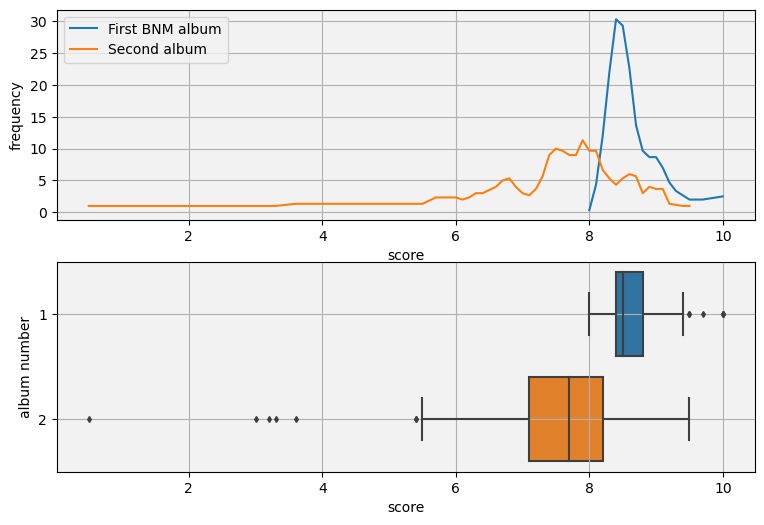

In [5]:
fig, ax = plt.subplots(2, figsize = (9,6))

# line plot
ax[0].plot(f['score'], f['count'], label = 'First BNM album') 
ax[0].plot(s['score'], s['count'], label = 'Second album') 
ax[0].legend(loc = 'best')
ax[0].set(xlabel='score', ylabel='frequency')
ax[0].grid()

# boxplot
sns.boxplot(data=temp_b, x='score', y='number', ax=ax[1], orient='h', fliersize=3)
ax[1].set(ylabel='album number')
ax[1].grid()

From the above, we're seeing what could be a statistically significant difference between the two groups. In particular, the middle quartiles of the two groups don't overlap at all.  

Revisiting the initial question: does winning BNM on the first album lead to lower review scores on the second album? So, our null hypothesis will be something like:  
&emsp; There is no significant difference between scores of BNM first albums and second albums.  

I was initially tempted to use the paired t-test here, since the two albums being scored are being released by the same artist just after some period of time. However, the two groups' scores are not being obtained from the same albums, so we'll use an independent t-test.  
  
Let's perform a t-test to test the **null hypothesis that there is no statistically significant difference between the scores of BNM first albums and those of subsequent second albums or that the expected values of the scores for these two types of albums is identical.**

In [6]:
stats.ttest_ind(first.score, second.score).pvalue

1.8244490157934708e-28

## Results

The minute pvalue (1.82e-28 <<< standard significance threshold of alpha = 0.05) tells us that we should **reject the null hypothesis.**  
So, we conclude that there is a significant difference in expected score of a first album awarded best new music and the artist's subsequent album. From our visualizations, we can confidently say that this difference is due to a decrease in score from the first to the second album.